In [57]:
# --- LAB 2: Exploratory Data Analysis (EDA) on REE Demand ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf




In [ ]:


# === 1. Load datasets ===
DemandaEnConsumo = pd.read_csv("export_DemandaEnConsumo_2025-11-07_17_53.csv", sep=';')

# Pulizia numeri 
DemandaEnConsumo['demand (MWh)'] = DemandaEnConsumo['demand (MWh)'].astype(str).str.replace('.', '', regex=False).astype(float)

# Conversion datetime (utc=true )
DemandaEnConsumo['datetime'] = pd.to_datetime(DemandaEnConsumo['datetime'], utc=True, errors='coerce')
DemandaEnConsumo['datetime'] = DemandaEnConsumo['datetime'].dt.tz_convert(None)

# order data
DemandaEnConsumo = DemandaEnConsumo.sort_values('datetime')

print("Shape:", DemandaEnConsumo.shape)
print("Shape:", preciomercadoSPOTDiario.shape)
print(DemandaEnConsumo.head())
print(preciomercadoSPOTDiario.head())


In [ ]:
preciomercadoSPOTDiario = pd.read_csv("export_PrecioMercadoSPOTDiario_2025-11-07_17_51.csv", sep=';')

# conversione numero e data
preciomercadoSPOTDiario['price (eur/MWh)'] = preciomercadoSPOTDiario['price (eur/MWh)'].astype(str).str.replace(',', '.').astype(float)
preciomercadoSPOTDiario['datetime'] = pd.to_datetime(preciomercadoSPOTDiario['datetime'], utc=True, errors='coerce').dt.tz_localize(None)

# ordina
preciomercadoSPOTDiario = preciomercadoSPOTDiario.sort_values('datetime')

print(preciomercadoSPOTDiario.head())

merged = pd.merge(DemandaEnConsumo, preciomercadoSPOTDiario, on='datetime', how='inner')
print(merged.shape)
print(merged.head())

Demand shape: (5088, 6)
Price shape: (8760, 6)
     id                name  geoid  geoname  demand (MWh)            datetime
0  1193  Demanda en consumo    NaN      NaN    21919561.0 2024-08-31 22:00:00
1  1193  Demanda en consumo    NaN      NaN    20683093.0 2024-08-31 23:00:00
    id                               name  geoid geoname  price (eur/MWh)  \
0  600  Precio mercado SPOT Diario España      3  España          13402.0   
1  600  Precio mercado SPOT Diario España      3  España          12916.0   

             datetime  
0 2024-08-31 22:00:00  
1 2024-08-31 23:00:00  


count    5.088000e+03
mean     2.189020e+07
std      7.640416e+06
min      1.848500e+04
25%      1.975104e+07
50%      2.341838e+07
75%      2.691050e+07
max      3.466050e+07
Name: demand (MWh), dtype: float64


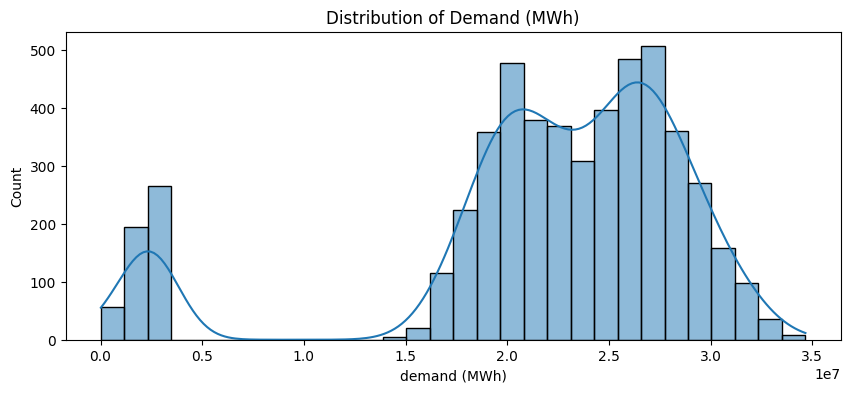

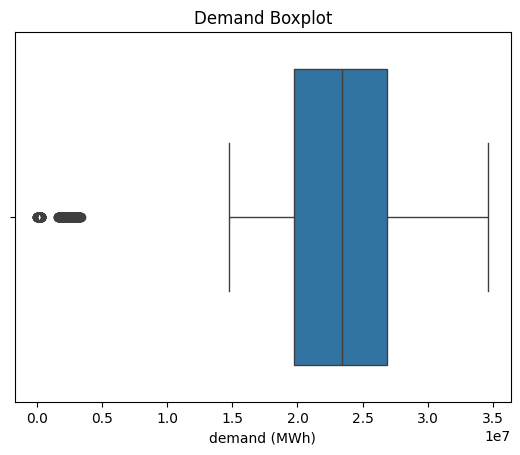

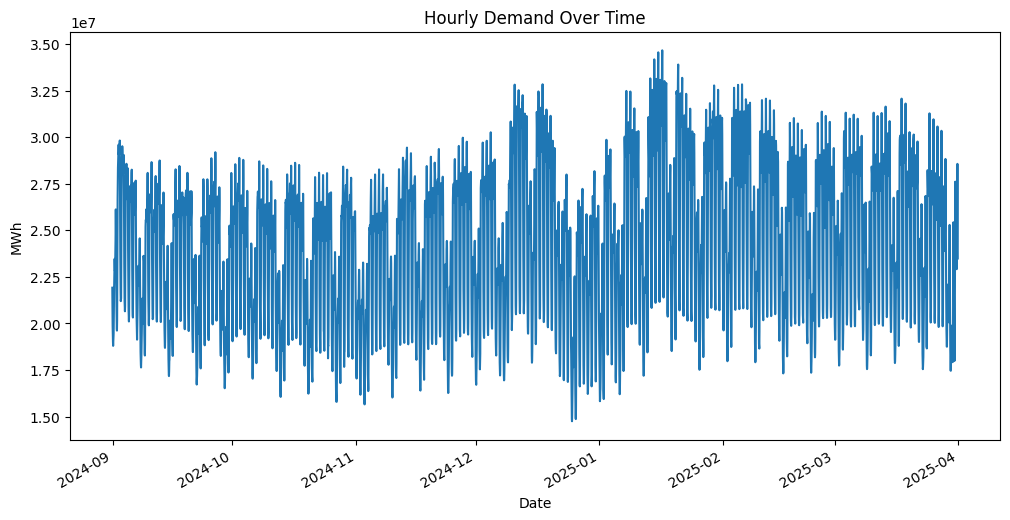

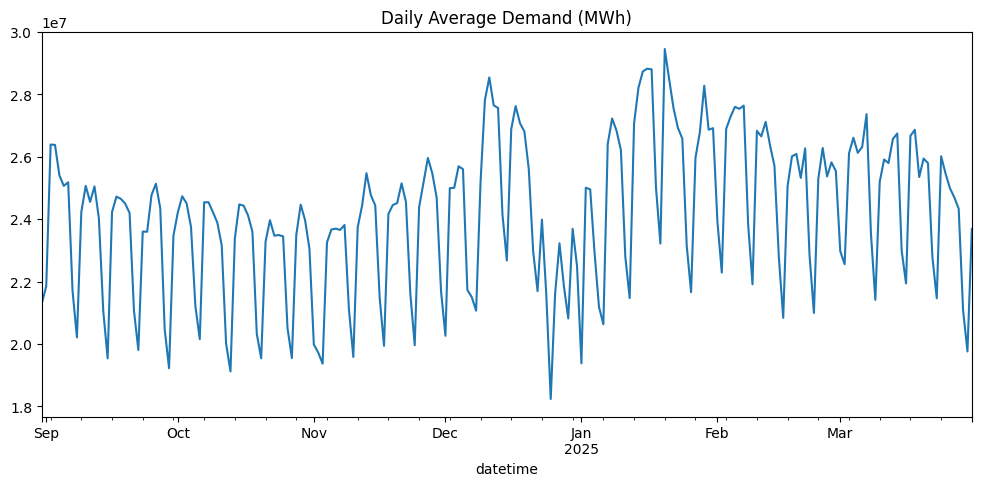

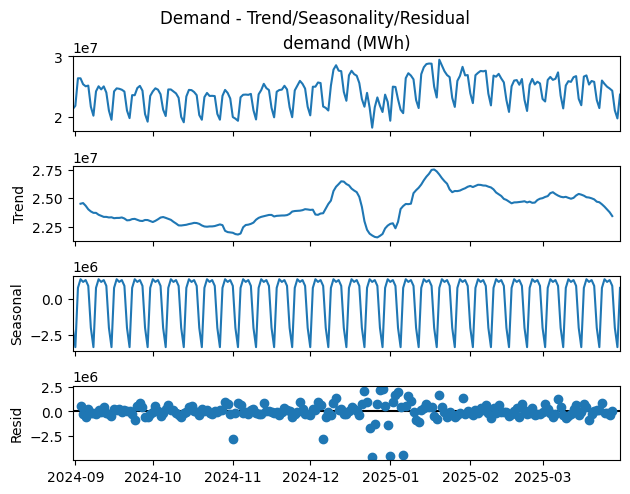

<Figure size 1000x500 with 0 Axes>

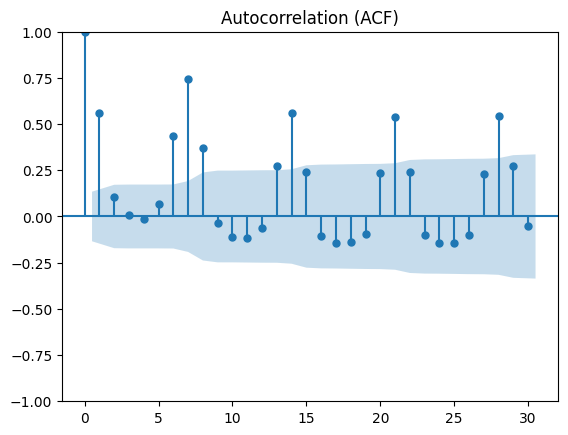

<Figure size 1000x500 with 0 Axes>

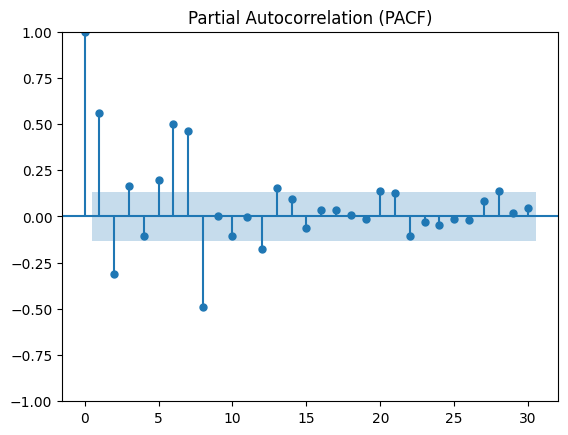

In [ ]:


# === 2. Feature engineering base ===
DemandaEnConsumo['Month'] = DemandaEnConsumo['datetime'].dt.month
DemandaEnConsumo['Weekday'] = DemandaEnConsumo['datetime'].dt.day_name()
DemandaEnConsumo['Hour'] = DemandaEnConsumo['datetime'].dt.hour
DemandaEnConsumo['is_weekend'] = DemandaEnConsumo['Weekday'].isin(['Saturday', 'Sunday'])

# === 3. Descriptive statistics ===
print(DemandaEnConsumo['demand (MWh)'].describe())

# === 4. Distribution and boxplot ===
plt.figure(figsize=(10,4))
sns.histplot(DemandaEnConsumo['demand (MWh)'], bins=30, kde=True)
plt.title('Distribution of Demand (MWh)')
plt.show()

sns.boxplot(x=DemandaEnConsumo['demand (MWh)'])
plt.title("Demand Boxplot")
plt.show()

# === 5. Remove outliers (IQR) ===
def remove_outliers_iqr(df, col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

clean = remove_outliers_iqr(DemandaEnConsumo, 'demand (MWh)')

# === 6. Time series ===
clean = clean.set_index('datetime').sort_index()

plt.figure(figsize=(12,6))
clean['demand (MWh)'].plot(color='tab:blue')
plt.title('Hourly Demand Over Time')
plt.xlabel('Date')
plt.ylabel('MWh')
plt.show()

# === 7. Daily aggregation ===
daily = clean['demand (MWh)'].resample('D').mean().dropna()
daily.plot(figsize=(12,5), title='Daily Average Demand (MWh)')
plt.show()

# === 8. Seasonal decomposition ===
decomp = seasonal_decompose(daily, period=7)
decomp.plot()
plt.suptitle('Demand - Trend/Seasonality/Residual', y=1.02)
plt.show()

# === 9. ACF/PACF ===
plt.figure(figsize=(10,5))
plot_acf(daily, lags=30)
plt.title('Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(10,5))
plot_pacf(daily, lags=30, method='ywm')
plt.title('Partial Autocorrelation (PACF)')
plt.show()


In [ ]:
# holes duplicate
missing = DemandaEnConsumo['datetime'].isna().sum()
dupes = DemandaEnConsumo.duplicated('datetime').sum()
print("NA datetime:", missing, "Duplicati:", dupes)

# coverage and continuity
idx = pd.date_range(DemandaEnConsumo['datetime'].min(),
                    DemandaEnConsumo['datetime'].max(), freq='H')
gap_idx = idx.difference(DemandaEnConsumo['datetime'])
print("Ore mancanti:", len(gap_idx))



NA datetime: 0 Duplicati: 0
Ore mancanti: 0


C:\Users\davide\AppData\Local\Temp\ipykernel_14504\1371211551.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx = pd.date_range(DemandaEnConsumo['datetime'].min(),


In [ ]:
DemandaEnConsumo['Hour'] = DemandaEnConsumo.index.hour
DemandaEnConsumo['DOW']  = DemandaEnConsumo.index.dayofweek  # 0=Mon ... 6=Sun

hour_profile = DemandaEnConsumo.groupby('Hour')['demand (MWh)'].mean()
dow_profile  = DemandaEnConsumo.groupby('DOW')['demand (MWh)'].mean()
ax = hour_profile.plot(title='medium profle hour'); plt.show()
ax = dow_profile.plot(kind='bar', title='medium profle hour week'); plt.show()


AttributeError: 'RangeIndex' object has no attribute 'hour'

In [ ]:
pvt = DemandaEnConsumo['demand (MWh)'].unstack(DemandaEnConsumo.index.hour)
plt.figure(figsize=(12,6))
sns.heatmap(pvt.T, cmap='viridis')
plt.title('Heatmap domanda: giorno × ora'); plt.xlabel('Giorni'); plt.ylabel('Ora')
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()